# Figures

In [1]:
import os
import nibabel as nb
import numpy as np
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'

fig_dir = '/home/shared/2018/visual/hcp_cerebellum/figs/'

try:
    os.mkdir(fig_dir)
except:
    print 'figdir already exists'
    
import h5py
import matplotlib.pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import glob
%matplotlib inline

import colorsys as cs

# note: dimensions in niftis:
# 0: angle
# 1: ecc
# 2: gain
# 3: meanvol
# 4: r2
# 5: size

dims = {
    'ang':0,
    'ecc':1,
    'gain':2,
    'meanvol':3,
    'r2':4,
    'rfsize':5
}





figdir already exists


In [2]:
def p_val_from_bootstrap_dist(distribution,test_value=0,two_tailed=True):
    """
    Finds p-value for hypothesis that the distribution is not different 
    from the test_value.

    :param distribution: distribution of bootstrapped parameter
    :type distribution: 1-D array
    :param test_value: value to test distribution against
    :type test_value: float
    :param two_tailed: if True, returns two-tailed test, else one-tailed
    :type two_tailed: bool

    :return p-val: p-val
    :type p-val: float
    """

    # see which part of the distribution falls below / above test value:
    proportion_smaller_than_test_value = np.sum(np.array(distribution) < test_value) / len(distribution)
    proportion_larger_than_test_value = np.sum(np.array(distribution) > test_value) / len(distribution)

    # take minimum value as p-val:
    p = np.min([proportion_smaller_than_test_value,proportion_larger_than_test_value])

    # this yields a one-tailed test, so multiply by 2 if we want a two-tailed p-val:
    if two_tailed:
        p*=2

    return p

def get_ci(distribution,ci_factor):

    from scipy import stats
    
    # convert ci factor to percentile
    perc_low = (stats.norm.sf(ci_factor))*100
    perc_high = (1 - (stats.norm.sf(ci_factor)))*100
    ci_low = np.percentile(distribution,perc_low)
    ci_high = np.percentile(distribution,perc_high)

    return [ci_low,ci_high]

def bootstrap_linear_fit(x_data,y_data,weights=None,test_value=0,ci_factor = 1.96,two_tailed=True,reps=1000):
    """
    Fits linear regression to data, either weighted or not. 
    Returns bootstrapped CIs for slope and intercept


    """
    # # set weights to one if none provided 
    if weights is None:
        weights = np.ones(len(x_data))

    # get random ints for random indices
    permute_indices = np.random.randint(0, len(x_data), size = (len(x_data), int(reps))).T

    slope_bootstrap_distr=[]
    intercept_bootstrap_distr=[]
    # loop over permutes
    for fold in permute_indices:
        # compute weighted linear fit
        slope,intercept=np.polyfit(x_data[fold], y_data[fold], 1,w=weights[fold])
        slope_bootstrap_distr.append(slope)
        intercept_bootstrap_distr.append(intercept)

    # get centers for slope and intercept by fitting to all data
    mean_slope,mean_intercept=np.polyfit(x_data, y_data, 1,w=weights)
    # slope distribution diagnostics
    ci_slope = get_ci(slope_bootstrap_distr,ci_factor)
    # ci_slope = np.std(slope_bootstrap_distr)*ci_factor
    p_slope = p_val_from_bootstrap_dist(slope_bootstrap_distr,test_value,two_tailed)

    # intercept distribution diagnostics
    # ci_intercept = np.std(intercept_bootstrap_distr)*ci_factor
    ci_intercept = get_ci(intercept_bootstrap_distr,ci_factor)
    p_intercept = p_val_from_bootstrap_dist(intercept_bootstrap_distr,test_value,two_tailed)

    return mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept

# create retmap snapshots for different maskings:

In [9]:

# load  subject nifti
mask = 'r2_spill_size'
fns = glob.glob(os.path.join(out_dir,'best_subjects',mask,'prfresults_subject_rank_avg.nii'))

for fn in fns:
   
    data=nb.load(fn).get_data()
    
    sj = fn.split('/')[-1].split('_')[2]
    mask = fn.split('/')[-1].split('_')[4].split('.')[0]

    pl.figure(figsize=(15,5))
    pl.title(sj)
    data[data==0] = np.nan
    pl.subplot(131)
    pl.imshow(data[52,25:50,5:20,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)
    pl.subplot(132)
    pl.imshow(data[30:60,38,5:20,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)
    pl.subplot(133)
    pl.imshow(data[20:70,30:50,11,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)

    pl.savefig(os.path.join(fig_dir,'volume_retmap_snapshots_sj_%s_mask_%s'%(sj,mask)))
    pl.close()


# avg subject plots

In [20]:
masktype = 'r2_spill_fix'

mask_names ={
'left_VI':1,
'right_VI':5,
'left_VIIb':2,
 'right_VIIb':7,
 'left_VIIIb':3,
 'right_VIIIb':6,
'left_crusI':4,
}

roi_combs = {
    'VI':[1,5],
    'VIIb':[2,7],
    'VIIIb':[3,6],
    'crus':[4]

}
roi_order = ['left_VI','left_VIIb','left_VIIIb','left_crusI','right_VI','right_VIIb','right_VIIIb']
roi_comb_order = ['VI','VIIb','VIIIb','crus']

# visualize distribution of pRF centers

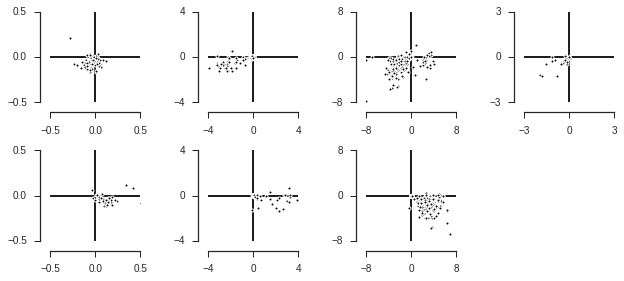

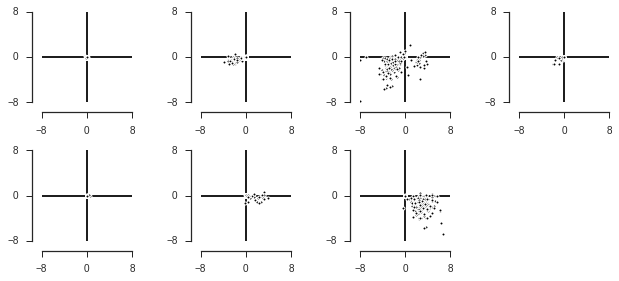

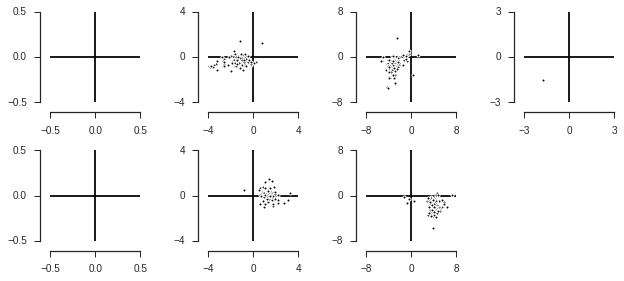

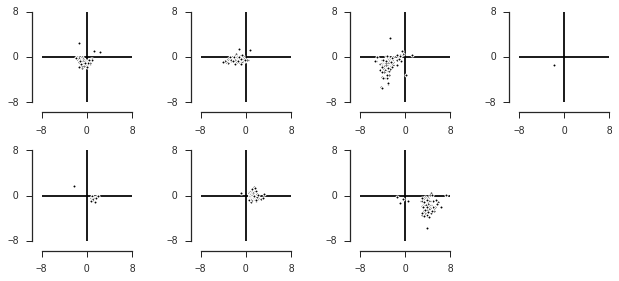

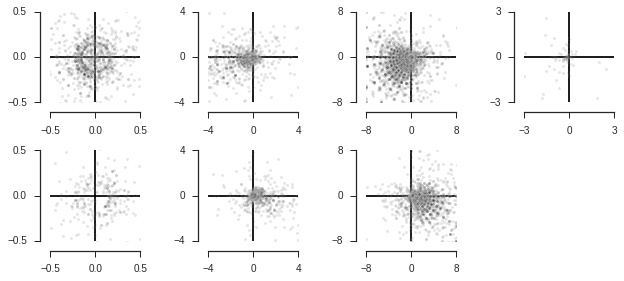

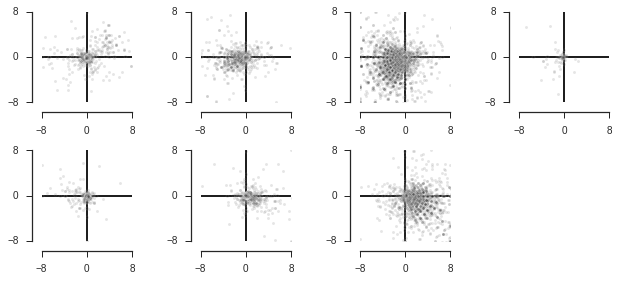

In [28]:
# scatter plot
pl.close('all')
for vis_type in ['scatter']:#,'hexbin']:
    for sub_type in ['avg','wavg','per']:#,'per']:
        for plot_type in ['zoomed_in','zoomed_out']:
            # first create a plot for the average subject
            f = pl.figure(figsize=(9,4))
            for mi,mask in enumerate(roi_order):

                s = f.add_subplot(2,4,mi+1,aspect='equal')

                roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

                if sub_type in ['avg','wavg']:

                    alpha = 1
                    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
                    xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])


                elif sub_type == 'per':

                    alpha = 0.1

                    all_xs = []
                    all_ys = []
                    for sj in range(181):

                        data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

                        xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                        ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])

                        all_xs.append(xs)
                        all_ys.append(ys)

                    xs = np.ravel(all_xs)
                    ys = np.ravel(all_ys)                    

                pl.axhline(0,color='k')
                pl.axvline(0,color='k')



                pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1,alpha=alpha)
#                 if len(xs) > 1:
# #                     if vis_type == 'scatter':
#                         sn.jointplot(x=xs,y=ys)#,'o',color='k',ms=3,mec='w',mew=1,alpha=alpha)
#                     elif vis_type == 'hexbin':
#                         sn.jointplot(xs,ys,kind='hex')#,'o',color='k',ms=3,mec='w',mew=1,alpha=alpha)
#                     print 'not plotting'

                if plot_type == 'zoomed_out':
                    maxecc = 8
                else:
                    if mask in ['left_VI','right_VI']:
                        maxecc = 0.5
                    elif 'VIIb' in mask:
                        maxecc = 4
                    elif 'VIIIb' in mask:
                        maxecc = 8
                    elif 'crus' in mask:
                        maxecc = 3

                pl.xlim(-maxecc,maxecc)
                pl.ylim(-maxecc,maxecc)   
                pl.xticks([-maxecc,0,maxecc])
                pl.yticks([-maxecc,0,maxecc])
                sn.despine(offset=10)
            pl.tight_layout()
            f.savefig(os.path.join(fig_dir,'prf_%s_avg_subject_%s_%s.png'%(vis_type,plot_type,sub_type)))

(118, 15)
(145, 15)
(151, 15)
(5, 15)


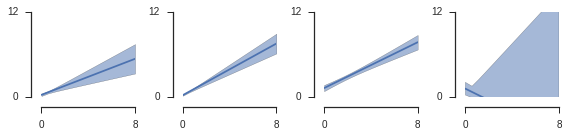

In [55]:
maxsize = 12
maxecc=8  
        
# eccen-size plot
for sub_type in ['fits_per']:#['wavg','avg','per']:

    f = pl.figure(figsize=(8,2))
    for mi,mask in enumerate(roi_comb_order):
        s = f.add_subplot(1,4,mi+1)

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        
        roimask = roimask.astype(bool)
        
            
        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            sizes = np.ravel(data[roimask,dims['rfsize']])
            eccs = np.ravel(data[roimask,dims['ecc']])
        
        elif sub_type == 'per':

            all_sizes = []
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_sizes.append(np.ravel(data[roimask,dims['rfsize']]))
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))
            eccs = np.ravel(all_eccs)
            sizes = np.ravel(all_sizes)  

        elif sub_type == 'fits_per':
            all_fits = []
            for sj in range(181):
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                r2s = np.ravel(data[roimask,dims['r2']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                eccs = np.ravel(data[roimask,dims['ecc']])
                v = (eccs < maxecc)*(sizes<maxsize)

                if v.sum() > 2:
                    p=np.polyfit(eccs[v], sizes[v], 1,w=r2s[v])
                    fit = np.polyval(p,np.linspace(0,maxecc,15))
                    all_fits.append(fit)
            
            print np.shape(all_fits)
            meanfit = np.mean(all_fits,axis=0)
            sefit = (np.std(all_fits,axis=0)*1.96)/np.sqrt(np.shape(all_fits)[0])
            pl.plot(np.linspace(0,maxecc,15),meanfit)
            pl.fill_between(np.linspace(0,maxecc,15),meanfit-sefit,meanfit+sefit,alpha=0.5)

                

        if sub_type != 'fits_per':
            v = (eccs < maxecc)*(sizes<maxsize)# * (eccs>.15) * (r2>9.8)
            try:
                sn.regplot(eccs[v],sizes[v],scatter_kws={'alpha':0.1})#,color = ['b'])
            except:
                print 'could not plot'
            
        pl.xlim(0,maxecc)
        pl.ylim(0,maxsize)
        pl.xticks([0,maxecc])
        pl.yticks([0,maxsize])

        sn.despine(offset=10)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_eccsize_%s.png'%sub_type))

could not plot


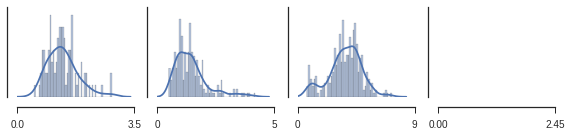

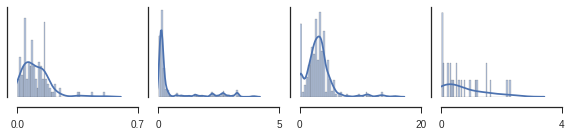

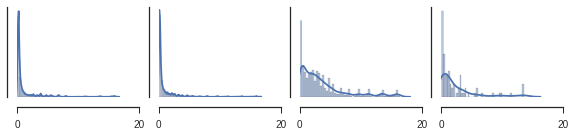

In [59]:
# ecc histogram
for sub_type in ['wavg','avg','per']:

    # first create a plot for the average subject
    f = pl.figure(figsize=(8,2))
    for mi,mask in enumerate(roi_comb_order):

        s = f.add_subplot(1,4,mi+1)
#         pl.title(mask)
        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        
        roimask = roimask.astype(bool)

#         roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            eccs = np.ravel(data[roimask,dims['ecc']])

#             eccs  = eccs[eccs > 0.1]
        elif sub_type == 'per':
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))

            eccs = np.ravel(all_eccs)
                
#             eccs = eccs[eccs>0.5]
            
#         if mask =='VI':
#             maxecc = 2
#         elif mask == 'VIIb':
#             maxecc = 4
#         elif mask == 'VIIIb':
#             maxecc = 12
#         elif mask == 'crus':
#             maxecc = 6
            
        
        try: 
            sn.distplot(eccs[~np.isnan(eccs)],bins=50)#,color = ['b'])
        except:
            print 'could not plot'
        pl.xlim(0,s.get_xlim()[1])
        pl.ylim(0,s.get_ylim()[1])
        pl.xticks([0,s.get_xlim()[1]])
        pl.yticks([])
        sn.despine(offset=10)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'ecc_histograms_%s.pdf'%sub_type))

could not plot


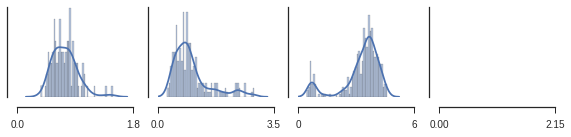

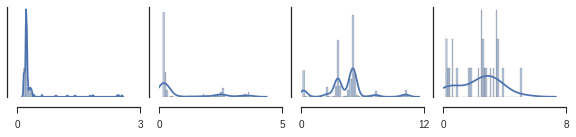

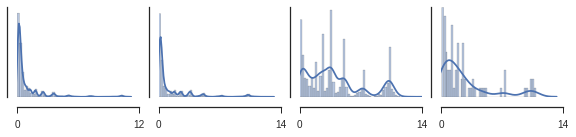

In [60]:
# ecc histogram
for sub_type in ['wavg','avg','per']:

    # first create a plot for the average subject
    f = pl.figure(figsize=(8,2))
    for mi,mask in enumerate(roi_comb_order):

        s = f.add_subplot(1,4,mi+1)
#         pl.title(mask)
        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        
        roimask = roimask.astype(bool)

#         roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            eccs = np.ravel(data[roimask,dims['rfsize']])

#             eccs  = eccs[eccs > 0.1]
        elif sub_type == 'per':
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_eccs.append(np.ravel(data[roimask,dims['rfsize']]))

            eccs = np.ravel(all_eccs)
        
        try: 
            sn.distplot(eccs[~np.isnan(eccs)],bins=50)#,color = ['b'])
        except:
            print 'could not plot'
        pl.xlim(0,s.get_xlim()[1])
        pl.ylim(0,s.get_ylim()[1])
        pl.xticks([0,s.get_xlim()[1]])
        pl.yticks([])
        sn.despine(offset=10)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'size_histograms_%s.pdf'%sub_type))

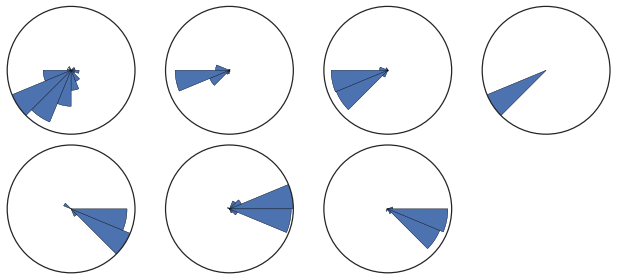

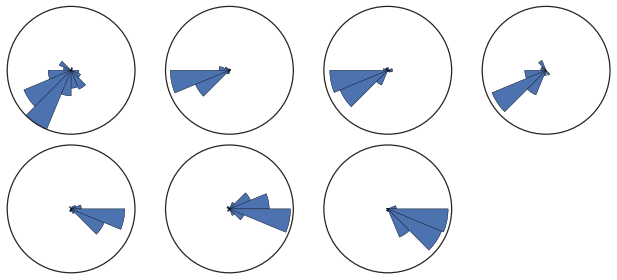

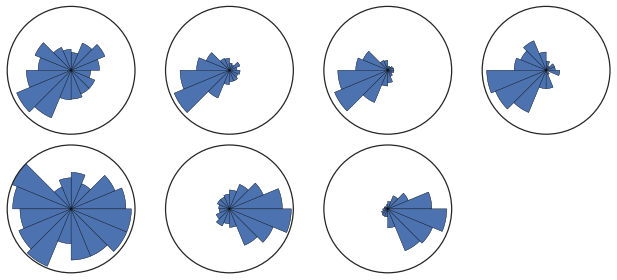

In [68]:
# polar histogram
for sub_type in ['wavg','avg','per']:

    # first create a plot for the average subject
    f = pl.figure(figsize=(9,4))
    for mi,mask in enumerate(roi_order):

        s = f.add_subplot(2,4,mi+1,projection='polar')
#         pl.title(mask)
        roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))


        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            angles = np.ravel(data[roimask,dims['ang']])

#             eccs  = eccs[eccs > 0.1]
        elif sub_type == 'per':
            all_angles = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_angles.append(np.ravel(data[roimask,dims['ang']]))

            angles = np.ravel(all_angles)
        
        angles = angles[~np.isnan(angles)]

        bins_number = 16
        bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
        radangs = np.radians(angles)
        n, _, _ = pl.hist(radangs, bins)

        width = 2 * np.pi / bins_number
        bars = s.bar(bins[:bins_number], n, width=width, bottom=0.0)
        for bar in bars:
            bar.set_alpha(0.5)
        pl.xticks([])
        pl.yticks([])

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'polar_histograms_%s.pdf'%sub_type))

# individual subject plots

slope is 0.877 greater than 0 with p = 0.000
slope is 0.877 greater than 0 with p = 0.000
slope is 0.847 greater than 0 with p = 0.000
slope is 0.854 greater than 0 with p = 0.000
slope is 0.749 greater than 0 with p = 0.000
slope is 0.710 greater than 0 with p = 0.000
slope is 0.769 greater than 0 with p = 0.000
slope is 0.915 greater than 0 with p = 0.000
slope is 1.530 greater than 0 with p = 0.000
slope is 1.070 greater than 0 with p = 0.000
slope is 1.192 greater than 0 with p = 0.000
slope is 1.192 greater than 0 with p = 0.000
slope is 1.635 greater than 0 with p = 0.000
slope is 1.635 greater than 0 with p = 0.000
slope is 0.723 greater than 0 with p = 0.000
slope is 0.801 greater than 0 with p = 0.000
slope is 0.525 greater than 0 with p = 0.000
slope is 0.525 greater than 0 with p = 0.000
slope is 1.221 greater than 0 with p = 0.000
slope is 1.221 greater than 0 with p = 0.000


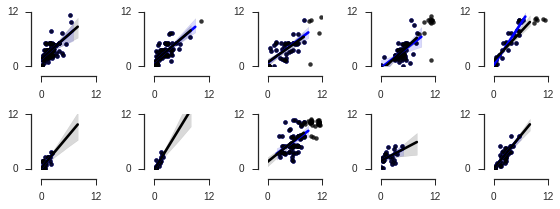

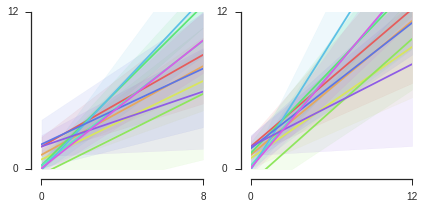

In [77]:
# get best 10 subjects

maxsize=12
# # # si-1
f = pl.figure(figsize=(8,3))
ecclim = 8
for sj in range(10):
    for ei, eccrange in enumerate([8,12]):

        s = f.add_subplot(2,5,sj+1,aspect='equal')

        # first create a plot for the average subject
        data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

        eccs = data[roimask,dims['ecc']]
        sizes = data[roimask,dims['rfsize']]

        v = (eccs<eccrange)

        sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
        # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(0,eccrange)
        pl.ylim(0,maxsize)
        pl.xticks([0,eccrange])
        pl.yticks([0,maxsize])
    sn.despine(offset=10)
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects.pdf'))

import colorsys
colors = np.array([colorsys.hsv_to_rgb(c,0.6,0.9) for c in np.linspace(0,1,12)])[:-2]

f = pl.figure(figsize=(6,3))
coefs = []

for sj in range(10):
    for ei, eccrange in enumerate([8,12]):

        s = f.add_subplot(1,2,ei+1)

        # first create a plot for the average subject
        data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

        eccs = data[roimask,dims['ecc']]
        sizes = data[roimask,dims['rfsize']]

        v = (eccs<eccrange)*(~np.isnan(eccs))
        mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])
        
        x = np.linspace(0,eccrange,10)
        
        fit = mean_intercept + mean_slope * x
        high_fit = ci_intercept[1] + ci_slope[1] * x
        low_fit = ci_intercept[0] + ci_slope[0] * x

        pl.fill_between(x,high_fit,low_fit,color=colors[sj],alpha=0.1)
        pl.plot(x,fit,c=colors[sj])
        
        print 'slope is %.3f greater than 0 with p = %.3f'%(mean_slope,p_slope)

#         pl.plot(x,c.intercept_[0]+c.coef_[0][0]*x,c=colors[si])


    #         sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
    #         # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(0,eccrange)
        pl.ylim(0,maxsize)
        pl.xticks([0,eccrange])
        pl.yticks([0,maxsize])
        sn.despine(offset=10)
    
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects_together.pdf'))     